# Part 2: Neural Network

In [1]:
# import libraries for reading data, exploring and plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# library for train test split
from sklearn.model_selection import train_test_split
# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# Experimentation with our data

In [2]:
# Load the csv into a pandas dataframe
spam_data = pd.read_csv('spam_or_not_spam\spam_or_not_spam.csv', sep =',',names=["email", "label"])
# Remove 1st line
spam_data = spam_data.iloc[1: , :]

In [3]:
spam_data.head()

,email,label
1,mike bostock said received from trackingNUMBE...,0
2,no i was just a little confused because i m r...,0
3,this is just an semi educated guess if i m wro...,0
4,jm URL justin mason writes except for NUMBER t...,0
5,i just picked up razor sdk NUMBER NUMBER and N...,0


In [4]:
spam_data.describe()

,email,label
count,1499,1500
unique,1376,2
top,url URL date not supplied URL,0
freq,10,1000


In [5]:
# Check for duplicates in the emails
duplicatedRow = spam_data[spam_data.duplicated()]
print(duplicatedRow[:5])

                                                 email label
306  use perl daily headline mailer this week on pe...     0
343  url URL date NUMBER NUMBER NUMBER NUMBER NUMBE...     0
350  url URL date NUMBER NUMBER NUMBER NUMBER NUMBE...     0
456                     url URL date not supplied URL      0
457                     url URL date not supplied URL      0


In [6]:
spam_data.groupby('label').describe().T

label                                      0  \
email count                             1000   
      unique                             949   
      top     url URL date not supplied URL    
      freq                                10   

label                                                         1  
email count                                                 499  
      unique                                                427  
      top     lowest rates available for term life insurance...  
      freq                                                    5

In [7]:
# Replace binary labels with 'good' and 'spam" labels
spam_data['label'] = spam_data['label'].replace('0','good')
spam_data['label'] = spam_data['label'].replace('1','spam')

In [8]:
spam_data.tail()

,email,label
1496,abc s good morning america ranks it the NUMBE...,spam
1497,hyperlink hyperlink hyperlink let mortgage le...,spam
1498,thank you for shopping with us gifts for all ...,spam
1499,the famous ebay marketing e course learn to s...,spam
1500,hello this is chinese traditional 子 件 NUMBER世...,spam


# Wordcloud Generator

In [9]:
# Gather all the good and spam emails in 2 different datasets
good_email = spam_data[spam_data.label=='good']
spam_email = spam_data[spam_data.label=='spam']
# Create numpy list to visualize using wordcloud (and take only the emails)
good_email_text = " ".join(good_email.email.to_numpy().tolist())
spam_email_text = " ".join(str(spam_email.email.to_numpy().tolist()))

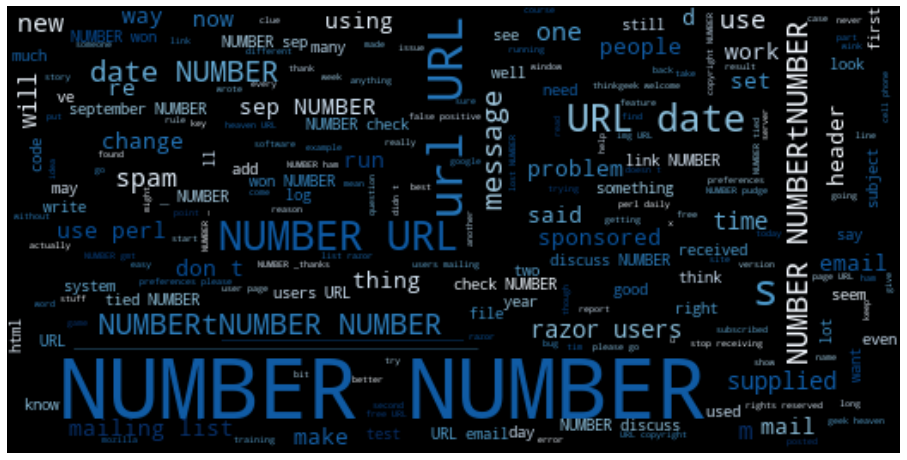

In [10]:
# wordcloud of good messages
good_email_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(good_email_text)
plt.figure(figsize=(16,10))
plt.imshow(good_email_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

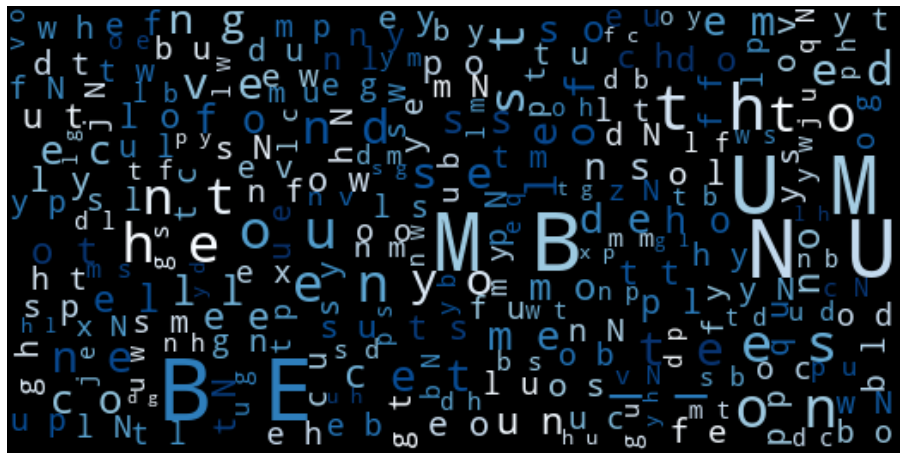

In [11]:
# wordcloud of spam messages
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(spam_email_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

# Handling imbalanced data

C:\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


50.0

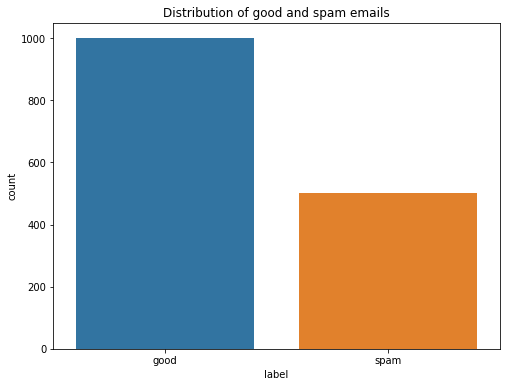

In [12]:
# we can observe imbalance in the data here 
plt.figure(figsize=(8,6))
plt.title('Distribution of good and spam emails')
sns.countplot(spam_data.label)
# Percentage of spam emails
(len(spam_email)/len(good_email))*100 # 50%

In [13]:
# One way to fix it is to downsample the good emails
good_email_df = good_email.sample(n = len(spam_email), random_state = 33)
spam_email_df = spam_email
print(good_email_df.shape, spam_email_df.shape)

(500, 2) (500, 2)


C:\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Message types')

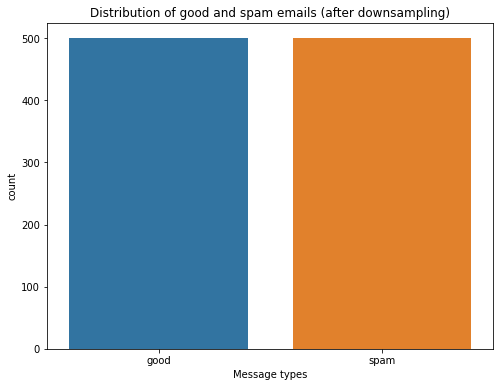

In [14]:
# Create a dataframe with good and spam email
email_df = good_email_df.append(spam_email_df).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.countplot(email_df.label)
plt.title('Distribution of good and spam emails (after downsampling)')
plt.xlabel('Message types')

In [15]:
# Length Information about our emails
# Get length column for each text
email_df['text_length'] = len(str(email_df['email']))
# Calculate average length by label types
labels = email_df.groupby('label').mean()
labels

,text_length
label,
good,667
spam,667


In [16]:
email_df.head()

,email,label,text_length
0,use perl daily headline mailer perl NUMBER rig...,good,667
1,url URL date wed NUMBER sep NUMBER NUMBER NUMB...,good,667
2,anthony baxter NUMBER sets each of NUMBERham ...,good,667
3,i just picked up razor sdk NUMBER NUMBER and N...,good,667
4,url URL date tue NUMBER sep NUMBER NUMBER NUMB...,good,667


# Prepare train/test data and pre-process text


In [17]:
spam_data = pd.read_csv('spam_or_not_spam\spam_or_not_spam.csv', sep =',',names=["email", "label"], skiprows=1)
spam_data = spam_data.astype(str) # Read correctly the type of emails
spam_data.head()

,email,label
0,mike bostock said received from trackingNUMBE...,0
1,no i was just a little confused because i m r...,0
2,this is just an semi educated guess if i m wro...,0
3,jm URL justin mason writes except for NUMBER t...,0
4,i just picked up razor sdk NUMBER NUMBER and N...,0


In [18]:
spam_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   1500 non-null   object
 1   label   1500 non-null   object
dtypes: object(2)
memory usage: 23.6+ KB


In [19]:
# Change the data type of the target column to int
spam_data["label"] = spam_data["label"].astype(str).astype(int)
# (fixes the "Cast string to float is not supported" issue)

In [20]:
# convert label to numpy arrays to fit deep learning models
email_labels = spam_data['label'].values

In [90]:
# Split data into train and test (75% + 25%)
train_emails, test_emails, train_labels, test_labels = train_test_split(spam_data['email'], email_labels, test_size=0.25, random_state=434)

### As deep learning models do not understand text, let’s convert text into numerical representation. For this purpose, a first step is Tokenization. The Tokenizer API from TensorFlow Keras splits sentences into words and encodes these into integers. Tokenizer() does all the required pre-processing such as tokenize into word or character — here we use at word level num_words for maximum number of unique tokens hence we can filter out rare words, filter out punctuation terms, convert all words to lower case, convert all words to integer index

In [91]:
# Defining pre-processing hyperparameters
max_len = 100 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 20000

In [92]:
# Tokenize the words
tokenizer = Tokenizer(num_words = vocab_size, lower=True, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_emails)

In [93]:
# Get the word_index 
word_index = tokenizer.word_index
# word_index

In [94]:
# Check how many words 
total_words = len(word_index)
print('There are %s unique words (tokens)  in training data. ' % total_words)

There are 19661 unique words (tokens)  in training data. 


#### After tokenization, we represent each sentence by sequences of numbers using texts_to_sequences() from tokenizer object. Subsequently, we use pad_sequences() so that each sequence will have same length. Sequencing and padding are done for both training and testing data.

# Sequencing and Padding


In [95]:
# Sequencing and padding on training and testing 
training_sequences = tokenizer.texts_to_sequences(train_emails)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )

testing_sequences = tokenizer.texts_to_sequences(test_emails)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
padding = padding_type, truncating = trunc_type)

In [96]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1125, 100)
Shape of testing tensor:  (375, 100)


In [97]:
# Before padding
len(training_sequences[0]), len(training_sequences[1])

(48, 94)

In [98]:
# After padding
len(training_padded[0]), len(training_padded[1])

(100, 100)

In [99]:
# Padded sequence of a first sentence
print(training_padded[0])

[   2  739    3  142   19 3152 1031  753 1075   16   13   54 1242    9
    2  495    4  564    2    2 2045   10    2  245 2208 2046 1076 1297
 4149    9    2   46    3 1673  475    8 1787   38  320 1115    9   27
    7 1358  133  197  899    9    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


# Training the model using a Dense architecture followed by LSTM and Bi-LSTM.

In [100]:
# Define hyper-parameters:
vocab_size = 20000 # As defined earlier
embeding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24

In [101]:
# Dense model architecture
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

In [102]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 16)           320000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                408       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 320,433
Trainable params: 320,433
Non-trainable params: 0
_________________________________________________________________


In [103]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

In [104]:
# fitting a dense spam detector model
num_epochs = 40
early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels), callbacks = [early_stop], verbose=2)

Epoch 1/40
36/36 - 1s - loss: 0.6759 - accuracy: 0.6667 - val_loss: 0.6512 - val_accuracy: 0.6613
Epoch 2/40
36/36 - 0s - loss: 0.6181 - accuracy: 0.6684 - val_loss: 0.5799 - val_accuracy: 0.6613
Epoch 3/40
36/36 - 0s - loss: 0.5408 - accuracy: 0.6791 - val_loss: 0.4951 - val_accuracy: 0.7227
Epoch 4/40
36/36 - 0s - loss: 0.4564 - accuracy: 0.8151 - val_loss: 0.4210 - val_accuracy: 0.8613
Epoch 5/40
36/36 - 0s - loss: 0.3808 - accuracy: 0.8827 - val_loss: 0.3542 - val_accuracy: 0.9173
Epoch 6/40
36/36 - 0s - loss: 0.3012 - accuracy: 0.9316 - val_loss: 0.2852 - val_accuracy: 0.9307
Epoch 7/40
36/36 - 0s - loss: 0.2329 - accuracy: 0.9484 - val_loss: 0.2284 - val_accuracy: 0.9440
Epoch 8/40
36/36 - 0s - loss: 0.1743 - accuracy: 0.9716 - val_loss: 0.1841 - val_accuracy: 0.9520
Epoch 9/40
36/36 - 0s - loss: 0.1348 - accuracy: 0.9769 - val_loss: 0.1526 - val_accuracy: 0.9600
Epoch 10/40
36/36 - 0s - loss: 0.1055 - accuracy: 0.9822 - val_loss: 0.1298 - val_accuracy: 0.9627
Epoch 11/40
36/36 -

### Accuracy and loss over epochs: Dense Classifier

In [105]:
# Model performance on test data 
model.evaluate(testing_padded, test_labels)

12/12 [==============================] - 0s 999us/step - loss: 0.0482 - accuracy: 0.9867


[0.0481659360229969, 0.9866666793823242]

In [106]:
# Read as a dataframe 
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

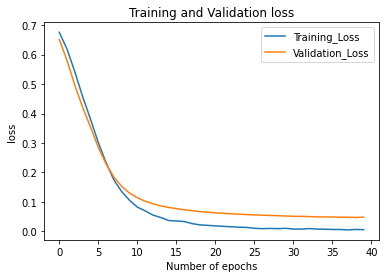

In [107]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

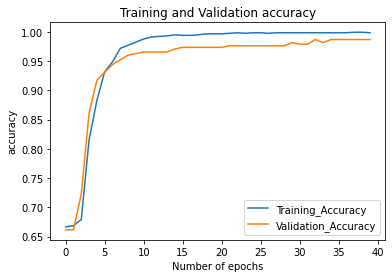

In [108]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

# Long Short Term Memory (LSTM) Model


In [109]:
#LSTM hyperparameters
n_lstm = 20
drop_lstm =0.2

In [110]:
#LSTM Spam detection architecture
model1 = Sequential()
model1.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(Dense(1, activation='sigmoid'))

In [111]:
# Compiling the LSTM model
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

# Training and evaluation LSTM model

In [112]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model1.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
36/36 - 7s - loss: 0.6459 - accuracy: 0.6657 - val_loss: 0.5848 - val_accuracy: 0.6613
Epoch 2/30
36/36 - 2s - loss: 0.4269 - accuracy: 0.8102 - val_loss: 0.2647 - val_accuracy: 0.9419
Epoch 3/30
36/36 - 2s - loss: 0.1781 - accuracy: 0.9671 - val_loss: 0.1719 - val_accuracy: 0.9611
Epoch 4/30
36/36 - 2s - loss: 0.1179 - accuracy: 0.9801 - val_loss: 0.1638 - val_accuracy: 0.9616
Epoch 5/30
36/36 - 2s - loss: 0.0941 - accuracy: 0.9841 - val_loss: 0.1452 - val_accuracy: 0.9661
Epoch 6/30
36/36 - 2s - loss: 0.0684 - accuracy: 0.9893 - val_loss: 0.1440 - val_accuracy: 0.9652
Epoch 7/30
36/36 - 2s - loss: 0.0489 - accuracy: 0.9926 - val_loss: 0.1353 - val_accuracy: 0.9670
Epoch 8/30
36/36 - 2s - loss: 0.0454 - accuracy: 0.9929 - val_loss: 0.0924 - val_accuracy: 0.9766
Epoch 9/30
36/36 - 2s - loss: 0.0350 - accuracy: 0.9949 - val_loss: 0.0935 - val_accuracy: 0.9781
Epoch 10/30
36/36 - 2s - loss: 0.0303 - accuracy: 0.9957 - val_loss: 0.1297 - val_accuracy: 0.9716


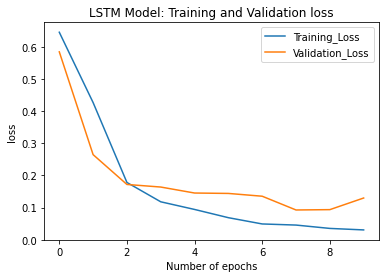

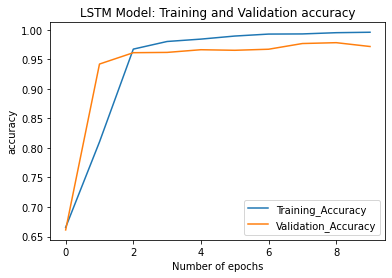

In [113]:
# Create a dataframe
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

# Bi-directional Long Short Term Memory (BiLSTM) Model


In [114]:
# Unlike in LSTM, the Bi-LSTM learns patterns from both before and after a given token within a document. The Bi-LSTM back-propagates in both backward and forward directions in time. Due to this, the computational time is increased compared to LSTM. However, in most of the cases Bi-LSTM results in better accuracy.

In [115]:
# Biderectional LSTM Spam detection architecture
model2 = Sequential()
model2.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model2.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)))
model2.add(Dense(1, activation='sigmoid'))

In [116]:
# Compiling the BiLSTM model
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [117]:
# Training
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model2.fit(training_padded, train_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
36/36 - 7s - loss: 0.6417 - accuracy: 0.6638 - val_loss: 0.5772 - val_accuracy: 0.6613
Epoch 2/30
36/36 - 1s - loss: 0.4737 - accuracy: 0.7452 - val_loss: 0.3036 - val_accuracy: 0.9183
Epoch 3/30
36/36 - 1s - loss: 0.1654 - accuracy: 0.9704 - val_loss: 0.1944 - val_accuracy: 0.9437
Epoch 4/30
36/36 - 1s - loss: 0.0970 - accuracy: 0.9809 - val_loss: 0.1539 - val_accuracy: 0.9494
Epoch 5/30
36/36 - 1s - loss: 0.0562 - accuracy: 0.9882 - val_loss: 0.1261 - val_accuracy: 0.9556
Epoch 6/30
36/36 - 1s - loss: 0.0373 - accuracy: 0.9922 - val_loss: 0.0935 - val_accuracy: 0.9658
Epoch 7/30
36/36 - 1s - loss: 0.0271 - accuracy: 0.9948 - val_loss: 0.1029 - val_accuracy: 0.9659
Epoch 8/30
36/36 - 1s - loss: 0.0222 - accuracy: 0.9974 - val_loss: 0.0992 - val_accuracy: 0.9655


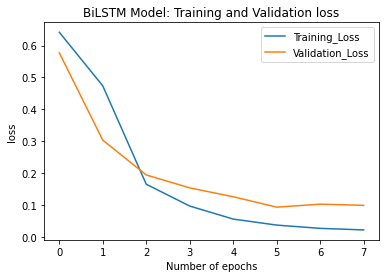

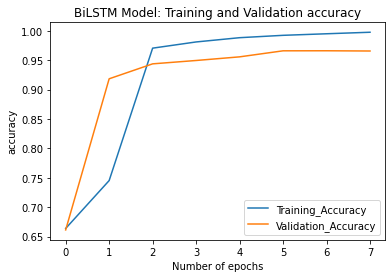

In [118]:
# Create a dataframe
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('BiLSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
# Plot
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

# Compare three different models and select a final one


In [119]:
# Comparing three different models
print(f"Dense architecture loss and accuracy: {model.evaluate(testing_padded, test_labels)} " )
print(f"LSTM architecture loss and accuracy: {model1.evaluate(testing_padded, test_labels)} " )
print(f"Bi-LSTM architecture loss and accuracy: {model2.evaluate(testing_padded, test_labels)} " )

12/12 [==============================] - 0s 1ms/step - loss: 0.0482 - accuracy: 0.9867
Dense architecture loss and accuracy: [0.0481659360229969, 0.9866666793823242] 
12/12 [==============================] - 0s 11ms/step - loss: 0.1297 - accuracy: 0.9716
LSTM architecture loss and accuracy: [0.12970510125160217, 0.9715733528137207] 
12/12 [==============================] - 0s 7ms/step - loss: 0.0992 - accuracy: 0.9655
Bi-LSTM architecture loss and accuracy: [0.09916412085294724, 0.9655199646949768] 


# Prediction of spam emails

# Scenario 1: Using raw text from our data:


In [120]:
# display long string 
pd.options.display.max_colwidth=200
spam_data[:1200]

,email,label
0,mike bostock said received from trackingNUMBER URL NUMBER NUMBER NUMBER NUMBER by URL postfix with esmtp id NUMBERedNUMBER for mike mydomain co uk sun NUMBER sep NUMBER NUMBER NUMBER NUMBER NUMBE...,0
1,no i was just a little confused because i m running procmail on a gateway and sits between the external sendmail box and internal exchange bridgehead server so there isn t any delivery to the loc...,0
2,this is just an semi educated guess if i m wrong someone please correct me spamd setuid s to the user running spamc since you re calling spamc from a global procmailrc file it s being run as root ...,0
3,jm URL justin mason writes except for NUMBER thing defanged mime messages that s a big problem but if you didn t just remove the headers and instead reverted back to the x spam prev versions it d ...,0
4,i just picked up razor sdk NUMBER NUMBER and NUMBER NUMBER agents from the the razor site i am using suse NUMBER NUMBER intalled sdk with no problems all tests passed when i try to make the NUMBER...,0
...,...,...
1195,take control of your computer with this top of the line software norton systemworks NUMBER software suite professional edition includes six yes NUMBER feature packed utilitiesall for NUMBER speci...,1
1196,the ultimate way to work from home the best money making system of all as seen on national tv as seen on NUMBER NUMBER and many other credible references this is not a scam i hope this is ok that ...,1
1197,sky your home refinance loan is approved to get your approved amount hyperlink go here to be excluded from further notices hyperlink go here sky NUMBERgate NUMBERgavjNUMBER NUMBERpgdaNUMBERkbfiNU...,1
1198,take control of your computer with this top of the line software norton systemworks NUMBER software suite professional edition includes six yes NUMBER feature packed utilitiesall for NUMBER speci...,1


In [125]:
predict_email = ["mike bostock said received from trackingNUMBER URL NUMBER NUMBER NUMBER NUMBER by URL postfix with esmtp id",
          "the ultimate way to work from home the best money making system of all as seen on national tv as seen on NUMBER NUMBER",
          "dear zzzz want to harvest a lot of email addresses in a very short time easy email searcher is a powerful"]


In [126]:
# Defining prediction function
def predict_spam(predict_email):
    new_seq = tokenizer.texts_to_sequences(predict_email)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (model.predict(padded))


In [127]:
predict_spam(predict_email)

array([[0.18675545],
       [0.8892162 ],
       [0.9564705 ]], dtype=float32)

# Scenario 2: Using newly created text and see how the model classifies them.

In [142]:
# The third one gives 0.99 indicating very high probabilty of spam
predict_email = ["You are awarded a new Digital Camera! Call now!",
               "It was nice meeting you at the University",
          "with this top of the line software norton systemworks"]
predict_spam(predict_email)

array([[0.932353  ],
       [0.7572621 ],
       [0.94742846]], dtype=float32)

# Summary / Observations:

### Our model seems to be highly accurate when it comes to predicting spam email related to the dataset. The certainty of a prediction increases if we input more words in the email. In the instances of few words, the model is more probable to consider the content as spam. In the case of randomly created messages it has a hard time predicting spam email, either because of the fewer words or a generally different format/style than the one used in our csv data. The neural network is accustomed to data similar to the ones used for the training, which are insufficient for it to be an accurate predictor of globally potential spam emails.